
# Using Replay Buffers

**Author**: [Vincent Moens](https://github.com/vmoens)


Replay buffers are a central piece of any RL or control algorithm.
Supervised learning methods are usually characterized by a training loop
where data is randomly pulled from a static dataset and fed successively
to the model and loss function.
In RL, things are often slightly different: the data is gathered using the
model, then temporarily stored in a dynamic structure (the experience
replay buffer), which serves as dataset for the loss module.

As always, the context in which the buffer is used drastically conditions
how it is built: some may wish to store trajectories when others will want
to store single transitions. Specific sampling strategies may be preferable
in contexts: some items can have a higher priority than others, or it can
be important to sample with or without replacement.
Computational factors may also come into play, such as the size of the buffer
which may exceed the available RAM storage.

For these reasons, TorchRL's replay buffers are fully composable: although
they come with "batteries included", requiring a minimal effort to be built,
they also support many customizations such as storage type,
sampling strategy or data transforms.


In this tutorial, you will learn:
- How to build a Replay Buffer (RB) and use it with any datatype;
- How to use RBs with TensorDict;
- How to sample from or iterate over a replay buffer, and how to define the sampling strategy;
- How to use prioritized replay buffers;
- How to transform data coming in and out from the buffer;
- How to store trajectories in the buffer.


## Basics: building a vanilla replay buffer

TorchRL's replay buffers are designed to prioritize modularity,
composability, efficiency, and simplicity. For instance, creating a basic
replay buffer is a straightforward process, as shown in the following
example:




In [1]:
from torchrl.data import ReplayBuffer

buffer = ReplayBuffer()

By default, this replay buffer will have a size of 1000. Let's check this
by populating our buffer using the :meth:`torchrl.data.ReplayBuffer.extend`
method:




In [2]:
print("length before adding elements:", len(buffer))

buffer.extend(range(2000))

print("length after adding elements:", len(buffer))

import torch
from tensordict import TensorDict

length before adding elements: 0
length after adding elements: 1000


We have used the :meth:`torchrl.data.ReplayBuffer.extend` method which is
designed to add multiple items all at once. If the object that is passed
to ``extend`` has more than one dimension, its first dimension is
considered to be the one to be split in separate elements in the buffer.
This essentially means that when adding multidimensional tensors or
tensordicts to the buffer, the buffer will only look at the first dimension
when counting the elements it holds in memory.
If the object passed it not iterable, an exception will be thrown.

To add items one at a time, the :meth:`torchrl.data.ReplayBuffer.add` method
should be used instead.

### Customizing the storage

We see that the buffer has been capped to the first 1000 elements that we
passed to it.
To change the size, we need to customize our storage.

TorchRL proposes three types of storages:

- The :class:`torchrl.dataListStorage` stores elements independently in a
  list. It supports any data type, but this flexibility comes at the cost
  of efficiency;
- The :class:`torchrl.dataLazyTensorStorage` stores tensors or
  :class:`tensordidct.TensorDict` (or :class:`torchrl.data.tensorclass`)
  objects. The storage is contiguous on a per-tensor basis, meaning that
  sampling will be more efficient than when using a list, but the
  implicit restriction is that any data passed to it must have the same
  basic properties as the
  first batch of data that was used to instantiate the buffer.
  Passing data that does not match this requirement will either raise an
  exception or lead to some undefined behaviours.
- The :class:`torchrl.dataLazyMemmapStorage` works as the
  :class:`torchrl.data.LazyTensorStorage` in that it is lazy (ie. it
  expects the first batch of data to be instantiated), and it requires data
  that match in shape and dtype for each batch stored. What makes this
  storage unique is that it points to disk files, meaning that it can
  support very large datasets while still accessing data in a contiguous
  manner.

Let us see how we can use each of these storages:



In [3]:
from torchrl.data import LazyMemmapStorage, LazyTensorStorage, ListStorage

# We define the maximum size of the buffer
size = 10_000

A buffer with a list storage buffer can store any kind of data (but we must
change the ``collate_fn`` since the default expects numerical data):



In [4]:
buffer_list = ReplayBuffer(storage=ListStorage(size), collate_fn=lambda x: x)
buffer_list.extend(["a", 0, "b"])
print(buffer_list.sample(3))

[0, 'a', 'a']


Because it is the one with the lowest amount of assumption, the
:class:`torchrl.data.ListStorage` is the default storage in TorchRL.

A :class:`torchrl.data.LazyTensorStorage` can store data contiguously.
This should be the preferred option when dealing with complicated but
unchanging data structures of medium size:



In [5]:
buffer_lazytensor = ReplayBuffer(storage=LazyTensorStorage(size))

Let us create a batch of data of size ``torch.Size([3])` with 2 tensors
stored in it:




In [6]:
data = TensorDict(
    {
        "a": torch.arange(12).view(3, 4),
        ("b", "c"): torch.arange(15).view(3, 5),
    },
    batch_size=[3],
)
print(data)

TensorDict(
    fields={
        a: Tensor(shape=torch.Size([3, 4]), device=cpu, dtype=torch.int64, is_shared=False),
        b: TensorDict(
            fields={
                c: Tensor(shape=torch.Size([3, 5]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([3]),
            device=None,
            is_shared=False)},
    batch_size=torch.Size([3]),
    device=None,
    is_shared=False)


The first call to :meth:`torchrl.data.ReplayBuffer.extend` will
instantiate the storage. The first dimension of the data is unbound into
separate datapoints:



In [7]:
buffer_lazytensor.extend(data)
print(f"The buffer has {len(buffer_lazytensor)} elements")

The buffer has 3 elements


Let us sample from the buffer, and print the data:




In [8]:
sample = buffer_lazytensor.sample(5)
print("samples", sample["a"], sample["b", "c"])

samples tensor([[ 4,  5,  6,  7],
        [ 0,  1,  2,  3],
        [ 8,  9, 10, 11],
        [ 0,  1,  2,  3],
        [ 0,  1,  2,  3]]) tensor([[ 5,  6,  7,  8,  9],
        [ 0,  1,  2,  3,  4],
        [10, 11, 12, 13, 14],
        [ 0,  1,  2,  3,  4],
        [ 0,  1,  2,  3,  4]])


A :class:`torchrl.data.LazyMemmapStorage` is created in the same manner:




In [9]:
buffer_lazymemmap = ReplayBuffer(storage=LazyMemmapStorage(size))
buffer_lazymemmap.extend(data)
print(f"The buffer has {len(buffer_lazymemmap)} elements")
sample = buffer_lazytensor.sample(5)
print("samples: a=", sample["a"], "\n('b', 'c'):", sample["b", "c"])

The buffer has 3 elements
samples: a= tensor([[ 0,  1,  2,  3],
        [ 8,  9, 10, 11],
        [ 8,  9, 10, 11],
        [ 0,  1,  2,  3],
        [ 8,  9, 10, 11]]) 
('b', 'c'): tensor([[ 0,  1,  2,  3,  4],
        [10, 11, 12, 13, 14],
        [10, 11, 12, 13, 14],
        [ 0,  1,  2,  3,  4],
        [10, 11, 12, 13, 14]])


We can also customize the storage location on disk:




In [10]:
buffer_lazymemmap = ReplayBuffer(
    storage=LazyMemmapStorage(size, scratch_dir="/tmp/memmap/")
)
buffer_lazymemmap.extend(data)
print(f"The buffer has {len(buffer_lazymemmap)} elements")
print("the 'a' tensor is stored in", buffer_lazymemmap._storage._storage["a"].filename)
print(
    "the ('b', 'c') tensor is stored in",
    buffer_lazymemmap._storage._storage["b", "c"].filename,
)

The buffer has 3 elements
the 'a' tensor is stored in /tmp/memmap/a.memmap
the ('b', 'c') tensor is stored in /tmp/memmap/b/c.memmap


## Integration with TensorDict

The tensor location follows the same structure as the TensorDict that
contains them: this makes it easy to save and load buffers during training.

To use :class:`tensordict.TensorDict` as a data carrier at its fullest
potential, the :class:`torchrl.data.TensorDictReplayBuffer` class should
be used.
One of its key benefits is its ability to handle the organization of sampled
data, along with any additional information that may be required
(such as sample indices).
It can be built in the same manner as a standard :class:`torchrl.data.ReplayBuffer` and can
generally be used interchangeably.




In [11]:
from torchrl.data import TensorDictReplayBuffer

buffer_lazymemmap = TensorDictReplayBuffer(
    storage=LazyMemmapStorage(size, scratch_dir="/tmp/memmap/"), batch_size=12
)
buffer_lazymemmap.extend(data)
print(f"The buffer has {len(buffer_lazymemmap)} elements")
sample = buffer_lazymemmap.sample()
print("sample:", sample)

The buffer has 3 elements
sample: TensorDict(
    fields={
        a: MemmapTensor(shape=torch.Size([12, 4]), device=cpu, dtype=torch.int64, is_shared=False),
        b: TensorDict(
            fields={
                c: MemmapTensor(shape=torch.Size([12, 5]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([12]),
            device=cpu,
            is_shared=False),
        index: Tensor(shape=torch.Size([12]), device=cpu, dtype=torch.int64, is_shared=False)},
    batch_size=torch.Size([12]),
    device=cpu,
    is_shared=False)


Our sample now has an extra ``"index"`` key that indicates what indices
were sampled.
Let us have a look at these indices:



In [12]:
print(sample["index"])

tensor([0, 1, 2, 1, 1, 2, 1, 2, 1, 2, 0, 1])


### Integration with tensorclass

The ReplayBuffer class and associated subclasses also work natively with
:class:`tensordict.tensorclass` classes, which can conviniently be used to
encode datasets in a more explicit manner:



In [13]:
from tensordict import tensorclass


@tensorclass
class MyData:
    images: torch.Tensor
    labels: torch.Tensor


data = MyData(
    images=torch.randint(
        255,
        (1000, 64, 64, 3),
    ),
    labels=torch.randint(100, (1000,)),
    batch_size=[1000],
)

buffer_lazymemmap = TensorDictReplayBuffer(
    storage=LazyMemmapStorage(size, scratch_dir="/tmp/memmap/"), batch_size=12
)
buffer_lazymemmap.extend(data)
print(f"The buffer has {len(buffer_lazymemmap)} elements")
sample = buffer_lazymemmap.sample()
print("sample:", sample)

The buffer has 1000 elements
sample: MyData(
    images=MemmapTensor(shape=torch.Size([12, 64, 64, 3]), device=cpu, dtype=torch.int64, is_shared=False),
    labels=MemmapTensor(shape=torch.Size([12]), device=cpu, dtype=torch.int64, is_shared=False),
    batch_size=torch.Size([12]),
    device=cpu,
    is_shared=False)


As expected. the data has the proper class and shape!

## Sampling and iterating over buffers

Replay Buffers support multiple sampling strategies:

- If the batch-size is fixed and can be defined at construction time, it can
  be passed as keyword argument to the buffer;
- With a fixed batch-size, the replay buffer can be iterated over to gather
  samples;
- If the batch-size is dynamic, it can be passed to the
  :class:`torchrl.data.ReplayBuffer.sample` method
  on-the-fly.

Sampling can be done using multithreading, but this is incompatible with the
last option (at it requires the buffer to know in advance the size of the
next batch).

Let us see a few examples:

### Fixed batch-size
If the batch-size is passed during construction, it should be ommited when
sampling:



In [14]:
buffer_lazymemmap = ReplayBuffer(storage=LazyMemmapStorage(size), batch_size=128)
buffer_lazymemmap.extend(data)
buffer_lazymemmap.sample()

MyData(
    images=MemmapTensor(shape=torch.Size([128, 64, 64, 3]), device=cpu, dtype=torch.int64, is_shared=False),
    labels=MemmapTensor(shape=torch.Size([128]), device=cpu, dtype=torch.int64, is_shared=False),
    batch_size=torch.Size([128]),
    device=cpu,
    is_shared=False)

This batch of data has the size that we wanted it to have (128).

To enable multithreaded sampling, just pass a positive integer to the
``prefetch`` keyword argument during construction. This should speed up
sampling considerably:



In [15]:
buffer_lazymemmap = ReplayBuffer(
    storage=LazyMemmapStorage(size), batch_size=128, prefetch=10
)  # creates a queue of 10 elements to be prefetched in the background
buffer_lazymemmap.extend(data)
print(buffer_lazymemmap.sample())

MyData(
    images=MemmapTensor(shape=torch.Size([128, 64, 64, 3]), device=cpu, dtype=torch.int64, is_shared=False),
    labels=MemmapTensor(shape=torch.Size([128]), device=cpu, dtype=torch.int64, is_shared=False),
    batch_size=torch.Size([128]),
    device=cpu,
    is_shared=False)


### Fixed batch-size, iterating over the buffer

We can also iterate over the buffer like we would do with a regular
dataloader, as long as the batch-size is predefined:



In [16]:
for i, data in enumerate(buffer_lazymemmap):
    if i == 3:
        print(data)
        break

MyData(
    images=MemmapTensor(shape=torch.Size([128, 64, 64, 3]), device=cpu, dtype=torch.int64, is_shared=False),
    labels=MemmapTensor(shape=torch.Size([128]), device=cpu, dtype=torch.int64, is_shared=False),
    batch_size=torch.Size([128]),
    device=cpu,
    is_shared=False)


Due to the fact that our sampling technique is entirely random and does not
prevent replacement, the iterator in question is infinite. However, we can
make use of the :class:`torchrl.data.replay_buffers.SamplerWithoutReplacement`
instead, which will transform our buffer into a finite iterator:




In [17]:
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement

buffer_lazymemmap = ReplayBuffer(
    storage=LazyMemmapStorage(size), batch_size=32, sampler=SamplerWithoutReplacement()
)

we create a data that is big enough to get a couple of samples



In [18]:
data = TensorDict(
    {
        "a": torch.arange(512).view(128, 4),
        ("b", "c"): torch.arange(1024).view(128, 8),
    },
    batch_size=[128],
)

buffer_lazymemmap.extend(data)
for _i, _ in enumerate(buffer_lazymemmap):
    continue
print(f"A total of {_i+1} batches have been collected")

A total of 4 batches have been collected


### Dynamic batch-size

In contrast to what we have seen earlier, the ``batch_size`` keyword
argument can be omitted and passed directly to the `sample` method:



In [19]:
buffer_lazymemmap = ReplayBuffer(
    storage=LazyMemmapStorage(size), sampler=SamplerWithoutReplacement()
)
buffer_lazymemmap.extend(data)
print("sampling 3 elements:", buffer_lazymemmap.sample(3))
print("sampling 5 elements:", buffer_lazymemmap.sample(5))

sampling 3 elements: TensorDict(
    fields={
        a: MemmapTensor(shape=torch.Size([3, 4]), device=cpu, dtype=torch.int64, is_shared=False),
        b: TensorDict(
            fields={
                c: MemmapTensor(shape=torch.Size([3, 8]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([3]),
            device=cpu,
            is_shared=False)},
    batch_size=torch.Size([3]),
    device=cpu,
    is_shared=False)
sampling 5 elements: TensorDict(
    fields={
        a: MemmapTensor(shape=torch.Size([5, 4]), device=cpu, dtype=torch.int64, is_shared=False),
        b: TensorDict(
            fields={
                c: MemmapTensor(shape=torch.Size([5, 8]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([5]),
            device=cpu,
            is_shared=False)},
    batch_size=torch.Size([5]),
    device=cpu,
    is_shared=False)


## Prioritized Replay buffers

TorchRL also provides an interface for prioritized replay buffers.
This buffer class samples data according to a priority signal that is passed
through the data.

Although this tool is compatible with non-tensordict data, we encourage
using TensorDict instead as it makes it possible to carry meta-data in and
out from the buffer with little effort.

Let us first see how to build a prioritized replay buffer in the generic
case. The $\alpha$ and $\beta$ hyperparameters
have to be manually set:



In [20]:
from torchrl.data.replay_buffers.samplers import PrioritizedSampler

size = 1000

rb = ReplayBuffer(
    storage=ListStorage(size),
    sampler=PrioritizedSampler(max_capacity=size, alpha=0.8, beta=1.1),
    collate_fn=lambda x: x,
)

Extending the replay buffer returns the items indices, which we will need
later to update the priority:



In [21]:
indices = rb.extend([1, "foo", None])

The sampler expects to have a priority for each element. When added to the
buffer, the priority is set to a default value of 1. Once the priority has
been computed (usually through the loss), it must be updated in the buffer.

This is done via the `update_priority` method, which requires the indices
as well as the priority.
We assign an artificially high priority to the second sample in the dataset
to observe its effect on sampling:




In [22]:
rb.update_priority(index=indices, priority=torch.tensor([1e-08, 1_000, 0.1]))

We observe that sampling from the buffer returns mostly the second sample
(``"foo"``):




In [23]:
sample, info = rb.sample(10, return_info=True)
print(sample)

['foo', 'foo', 'foo', 'foo', 'foo', 'foo', 'foo', 'foo', 'foo', 'foo']


The info contains the relative weights of the items as well as the indices.



In [24]:
print(info)

{'_weight': array([3.845086e-10, 3.845086e-10, 3.845086e-10, 3.845086e-10,
       3.845086e-10, 3.845086e-10, 3.845086e-10, 3.845086e-10,
       3.845086e-10, 3.845086e-10], dtype=float32), 'index': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}


In [25]:
prios = torch.tensor([1e-08, 1_000, 0.1])**0.8
prios /= prios.sum()
w = (1000*prios)**(-1.1)
w /= w.max()
w

tensor([1.0000e+00, 2.0893e-10, 6.9183e-07])

In [43]:
from torchrl.data import LazyTensorStorage, LazyMemmapStorage, ListStorage, TensorDictPrioritizedReplayBuffer


rb = TensorDictPrioritizedReplayBuffer(
                alpha = 1.0,#0.7,
                beta = 1.0,#1.1,
                priority_key="td_error",
                #storage=ListStorage(self.buffer_size),
                storage=LazyTensorStorage(1000),
                #collate_fn=lambda x: x, 
                batch_size=10,
            )

indices = rb.add(data)

KeyboardInterrupt: 

We see that using a prioritized replay buffer requires a series of extra
steps in the training loop compared with a regular buffer:
- After collecting data and extending the buffer, the priority of the
  items must be updated;
- After computing the loss and getting a "priority signal" from it, we must
  update again the priority of the items in the buffer.
  This requires us to keep track of the indices.

This drastically hampers the reusability of the buffer: if one is to write
a training script where both a prioritized and a regular buffer can be
created, she must add a considerable amount of control flow to make sure
that the appropriate methods are called at the appropriate place, if and
only if a prioritized buffer is being used.

Let us see how we can improve this with TensorDict. We saw that the
:class:`torchrl.data.TensorDictReplayBuffer` returns data augmented with
their relative storage indices. One feature we did not mention is that
this class also ensures that the priority
signal is automatically parsed to the prioritized sampler if present during
extension.

The combination of these features simplifies things in several ways:
- When extending the buffer, the priority signal will automatically be
  parsed if present and the priority will accurately be assigned;
- The indices will be stored in the sampled tensordicts, making it easy to
  update the priority after the loss computation.
- When computing the loss, the priority signal will be registered in the
  tensordict passed to the loss module, making it possible to update the
  weights without effort:

     >>> data = replay_buffer.sample()
     >>> loss_val = loss_module(data)
     >>> replay_buffer.update_tensordict_priority(data)

The following code illustrates these concepts. We build a replay buffer with
a prioritized sampler, and indicate in the constructor the entry where
the priority signal should be fetched:



In [27]:
rb = TensorDictReplayBuffer(
    storage=ListStorage(size),
    sampler=PrioritizedSampler(size, alpha=0.8, beta=1.1),
    priority_key="td_error",
    batch_size=1024,
)

Let us choose a priority signal that is proportional to the storage index:




In [28]:
data["td_error"] = torch.arange(data.numel())

rb.extend(data)

sample = rb.sample()

higher indices should occur more frequently:



(array([ 15.,  38.,  51.,  85.,  99., 117., 150., 130., 176., 163.]),
 array([  1. ,  13.6,  26.2,  38.8,  51.4,  64. ,  76.6,  89.2, 101.8,
        114.4, 127. ]),
 <BarContainer object of 10 artists>)

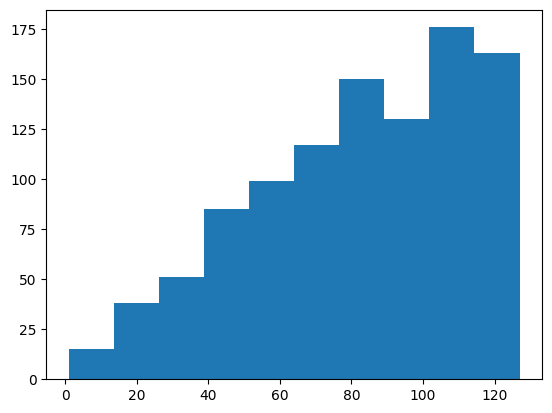

In [29]:
from matplotlib import pyplot as plt

plt.hist(sample["index"].numpy())

Once we have worked with our sample, we update the priority key using
the :meth:`torchrl.data.TensorDictReplayBuffer.update_tensordict_priority`
method.
For the sake of showing how this works, let us revert the priority of the
sampled items:




In [30]:
sample = rb.sample()
sample["td_error"] = data.numel() - sample["index"]
rb.update_tensordict_priority(sample)

Now, higher indices should occur less frequently:



(array([166., 173., 125., 132., 130.,  97.,  81.,  55.,  34.,  31.]),
 array([  1. ,  13.4,  25.8,  38.2,  50.6,  63. ,  75.4,  87.8, 100.2,
        112.6, 125. ]),
 <BarContainer object of 10 artists>)

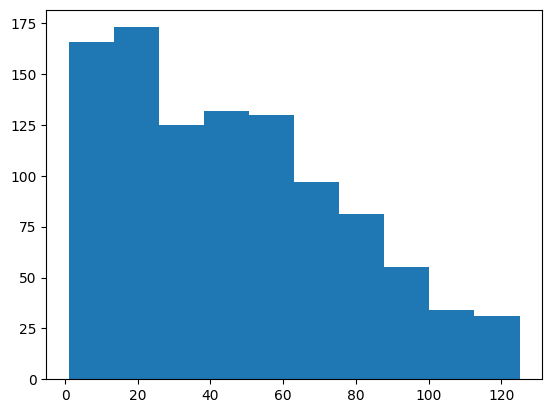

In [31]:
sample = rb.sample()
from matplotlib import pyplot as plt

plt.hist(sample["index"].numpy())

## Using transforms

The data stored in a replay buffer may not be ready to be presented to a
loss module.
In some cases, the data produced by a collector can be too heavy to be
saved as-is. Examples of this include converting images from ``uint8`` to
floating point tensors, or concatenating successive frames when using
decision transformers.

Data can be processed in and out of a buffer just by appending the
appropriate transform to it.
Here are a few examples:

### Saving raw images

``uint8``-typed tensors are comparatively much less memory expensive than
the floating point tensors we usually feed to our models. For this reason,
it can be useful to save the raw images.
The following script show how one can build a collector that returns only
the raw images but uses the transformed ones for inference, and how these
transformations can be recycled in the replay buffer:



In [32]:
from torchrl.collectors import RandomPolicy, SyncDataCollector
from torchrl.envs import Compose, GrayScale, Resize, ToTensorImage, TransformedEnv
from torchrl.envs.libs.gym import GymEnv

env = TransformedEnv(
    GymEnv("CartPole-v1", from_pixels=True),
    Compose(
        ToTensorImage(in_keys=["pixels"], out_keys=["pixels_trsf"]),
        Resize(in_keys=["pixels_trsf"], w=64, h=64),
        GrayScale(in_keys=["pixels_trsf"]),
    ),
)

let us have a look at a rollout:



In [33]:
print(env.rollout(3))

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([3, 2]), device=cpu, dtype=torch.int64, is_shared=False),
        done: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                pixels: Tensor(shape=torch.Size([3, 400, 600, 3]), device=cpu, dtype=torch.uint8, is_shared=False),
                pixels_trsf: Tensor(shape=torch.Size([3, 1, 64, 64]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([3]),
            device=cpu,
            is_shared=False),
        pixels: Tensor(shape=torch.Size([3, 400, 600, 3]), device=cpu, dtype=torch.uint8, is_shared=False),
        pixels_trsf: Tensor(shape=torch.Size([3, 1, 64, 64]), device=cpu, dtype=torc

We have just created an environment that produces pixels. These images
are processed to be fed to a policy.
We would like to store the raw images, and not their transforms.
To do this, we will append a transform to the collector to select the keys
we want to see appearing:



In [34]:
from torchrl.envs import ExcludeTransform

collector = SyncDataCollector(
    env,
    RandomPolicy(env.action_spec),
    frames_per_batch=10,
    total_frames=1000,
    postproc=ExcludeTransform("pixels_trsf", ("next", "pixels_trsf"), "collector"),
)

Let us have a look at a batch of data, and control that the
``"pixels_trsf"`` keys have been discarded:



In [35]:
for data in collector:
    print(data)
    break

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([10, 2]), device=cpu, dtype=torch.int64, is_shared=False),
        done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                pixels: Tensor(shape=torch.Size([10, 400, 600, 3]), device=cpu, dtype=torch.uint8, is_shared=False),
                reward: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([10]),
            device=cpu,
            is_shared=False),
        pixels: Tensor(shape=torch.Size([10, 400, 600, 3]), device=cpu, dtype=torch.uint8, is_shared=False)},
    batch_size=torch.Size([10]),
    device=cpu,
    is_shared=False)


We create a replay buffer with the same transform as the environment.
There is, however, a detail that needs to be addressed: transforms
used without environments are oblivious to the data structure.
When appending a transform to an environment, the data in the ``"next"``
nested tensordict is transformed first and then copied at the root during
the rollout execution. When working with static data, this is not the case.
Nevertheless, our data comes with a nested "next" tensordict that will be
ignored by our transform if we don't explicitly instruct it to take care of
it. We manually add these keys to the transform:



In [36]:
t = Compose(
    ToTensorImage(
        in_keys=["pixels", ("next", "pixels")],
        out_keys=["pixels_trsf", ("next", "pixels_trsf")],
    ),
    Resize(in_keys=["pixels_trsf", ("next", "pixels_trsf")], w=64, h=64),
    GrayScale(in_keys=["pixels_trsf", ("next", "pixels_trsf")]),
)
rb = TensorDictReplayBuffer(storage=LazyMemmapStorage(1000), transform=t, batch_size=16)
rb.extend(data)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

We can check that a ``sample`` method sees the transformed images reappear:




In [37]:
print(rb.sample())

TensorDict(
    fields={
        action: MemmapTensor(shape=torch.Size([16, 2]), device=cpu, dtype=torch.int64, is_shared=False),
        done: MemmapTensor(shape=torch.Size([16, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        index: Tensor(shape=torch.Size([16]), device=cpu, dtype=torch.int64, is_shared=False),
        next: TensorDict(
            fields={
                done: MemmapTensor(shape=torch.Size([16, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                pixels: MemmapTensor(shape=torch.Size([16, 400, 600, 3]), device=cpu, dtype=torch.uint8, is_shared=False),
                pixels_trsf: Tensor(shape=torch.Size([16, 1, 64, 64]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: MemmapTensor(shape=torch.Size([16, 1]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([16]),
            device=cpu,
            is_shared=False),
        pixels: MemmapTensor(shape=torch.Size([16, 400, 600,

### A more complex examples: using CatFrames

The :class:`torchrl.envs.CatFrames` transform unfolds the observations
through time, creating a n-back memory of past events that allow the model
to take the past events into account (in the case of POMDPs or with
recurrent policies such as Decision Transformers). Storing these concatenated
frames can consume a considerable amount of memory. It can also be
problematic when the n-back window needs to be different (usually longer)
during training and inference. We solve this problem by executing the
``CatFrames`` transform separately in the two phases.



In [38]:
from torchrl.envs import CatFrames, UnsqueezeTransform

We create a standard list of transforms for environments that return pixel-based
observations:



In [39]:
env = TransformedEnv(
    GymEnv("CartPole-v1", from_pixels=True),
    Compose(
        ToTensorImage(in_keys=["pixels"], out_keys=["pixels_trsf"]),
        Resize(in_keys=["pixels_trsf"], w=64, h=64),
        GrayScale(in_keys=["pixels_trsf"]),
        UnsqueezeTransform(-4, in_keys=["pixels_trsf"]),
        CatFrames(dim=-4, N=4, in_keys=["pixels_trsf"]),
    ),
)
collector = SyncDataCollector(
    env,
    RandomPolicy(env.action_spec),
    frames_per_batch=10,
    total_frames=1000,
)
for data in collector:
    print(data)
    break

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([10, 2]), device=cpu, dtype=torch.int64, is_shared=False),
        collector: TensorDict(
            fields={
                traj_ids: Tensor(shape=torch.Size([10]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([10]),
            device=cpu,
            is_shared=False),
        done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                pixels: Tensor(shape=torch.Size([10, 400, 600, 3]), device=cpu, dtype=torch.uint8, is_shared=False),
                pixels_trsf: Tensor(shape=torch.Size([10, 4, 1, 64, 64]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=

The buffer transform looks pretty much like the environment one, but with
extra ``("next", ...)`` keys like before:




In [40]:
t = Compose(
    ToTensorImage(
        in_keys=["pixels", ("next", "pixels")],
        out_keys=["pixels_trsf", ("next", "pixels_trsf")],
    ),
    Resize(in_keys=["pixels_trsf", ("next", "pixels_trsf")], w=64, h=64),
    GrayScale(in_keys=["pixels_trsf", ("next", "pixels_trsf")]),
    CatFrames(dim=-4, N=4, in_keys=["pixels_trsf", ("next", "pixels_trsf")]),
)
rb = TensorDictReplayBuffer(storage=LazyMemmapStorage(1000), transform=t, batch_size=16)
data_exclude = data.exclude("pixels_trsf", ("next", "pixels_trsf"))
rb.add(data_exclude)

0

Let us sample one element from the buffer. The shape of the transformed
pixel keys should have a length of 4 along the 4th dimension starting from
the end:




In [41]:
s = rb.sample(1)  # the buffer has only one element
print(s)

TensorDict(
    fields={
        action: MemmapTensor(shape=torch.Size([1, 10, 2]), device=cpu, dtype=torch.int64, is_shared=False),
        collector: TensorDict(
            fields={
                traj_ids: MemmapTensor(shape=torch.Size([1, 10]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([1, 10]),
            device=cpu,
            is_shared=False),
        done: MemmapTensor(shape=torch.Size([1, 10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        index: Tensor(shape=torch.Size([1, 10]), device=cpu, dtype=torch.int64, is_shared=False),
        next: TensorDict(
            fields={
                done: MemmapTensor(shape=torch.Size([1, 10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                pixels: MemmapTensor(shape=torch.Size([1, 10, 400, 600, 3]), device=cpu, dtype=torch.uint8, is_shared=False),
                pixels_trsf: Tensor(shape=torch.Size([1, 10, 4, 1, 64, 64]), device=cpu, dtype=torch.float32, is

/home/nono/.conda/envs/torch_rl/lib/python3.9/site-packages/torchrl/data/replay_buffers/replay_buffers.py:378: UserWarning: Got conflicting batch_sizes in constructor (16) and `sample` (1). Refer to the ReplayBuffer documentation for a proper usage of the batch-size arguments. The batch-size provided to the sample method will prevail.
  warnings.warn(


After a bit of processing (excluding non-used keys etc), we see that the
data generated online and offline match!



In [42]:
assert (data.exclude("collector") == s.squeeze(0).exclude("index", "collector")).all()

## Conclusion

We have seen how a replay buffer can be used in TorchRL, from its simplest
usage to more advanced ones where the data need to be transformed or stored
in particular ways.
You should now be able to:

- Create a Replay Buffer, customize its storage, sampler and transforms;
- Choose the best storage type for your problem (list, memory or disk-based);
- Minimize the memory footprint of your buffer.


